## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# import seaborn as sns
# sns.set()

import pandas as pd

import time

import random

import os

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
os.getcwd()

'C:\\Users\\Trey\\Documents\\GitHub\\manifolder\\code\\astro\\final_notebooks'

In [3]:
import sys
# sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")
sys.path.append(r"../..")

sys.path.append("/home/jovyan/gen-mod-vol/avlab/manifolder/code")

import manifolder as mr
from manifolder import helper as mh


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# load the data
# note, you must have started the notebook in the 
print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [5]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [6]:
import pickle
#Load Data
segments = np.load('themis/segments-newdata-all.npy')

# Load Labels
labels = np.load('themis/labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [7]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

reduce_dimension = True

for i in range(snippet_len,data_raw.shape[0]+1,snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,0]
        snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
s

In [8]:
len(locallabel)

104

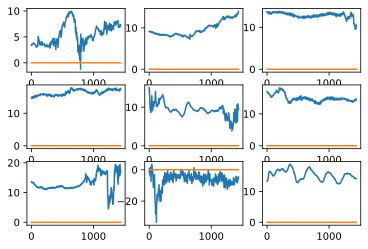

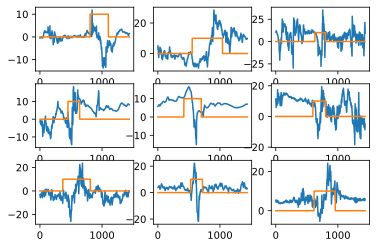

In [9]:
# import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()



dim=6
H = 160
step_size = 20
nbins = 10
ncov = 10
num_rdims = 10

In [10]:
# data has been parsed, now run Manifolder


start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov, num_rdims=num_rdims)

# add the data, and fit (this runs all the functions)
# manifolder.fit_transform(zs, parallel=False, dtw="raw")
# manifolder.fit_transform(zs, parallel=True)
manifolder.fit_transform(zs)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


calculating histograms for snip  0  of  104  (dim  1  timeseries) . done
calculating histograms for snip  1  of  104  (dim  1  timeseries) . done
calculating histograms for snip  2  of  104  (dim  1  timeseries) . done
calculating histograms for snip  3  of  104  (dim  1  timeseries) . done
calculating histograms for snip  4  of  104  (dim  1  timeseries) . done
calculating histograms for snip  5  of  104  (dim  1  timeseries) . done
calculating histograms for snip  6  of  104  (dim  1  timeseries) . done
calculating histograms for snip  7  of  104  (dim  1  timeseries) . done
calculating histograms for snip  8  of  104  (dim  1  timeseries) . done
calculating histograms for snip  9  of  104  (dim  1  timeseries) . done
calculating histograms for snip  10  of  104  (dim  1  timeseries) . done
calculating histograms for snip  11  of  104  (dim  1  timeseries) . done
calculating histograms for snip  12  of  104  (dim  1  timeseries) . done
calculating histograms for snip  13  of  104  (d

computing local covariances for snip  8  of  104......... done
computing local covariances for snip  9  of  104......... done
computing local covariances for snip  10  of  104......... done
computing local covariances for snip  11  of  104......... done
computing local covariances for snip  12  of  104......... done
computing local covariances for snip  13  of  104......... done
computing local covariances for snip  14  of  104......... done
computing local covariances for snip  15  of  104......... done
computing local covariances for snip  16  of  104......... done
computing local covariances for snip  17  of  104......... done
computing local covariances for snip  18  of  104......... done
computing local covariances for snip  19  of  104......... done
computing local covariances for snip  20  of  104......... done
computing local covariances for snip  21  of  104......... done
computing local covariances for snip  22  of  104......... done
computing local covariances for snip  23  

In [11]:
# calculate energy distance matrix for dimension reduced data from manifolder

snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_psi[i], snippet_psi[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)


	 Dcor Executed in 1.57 seconds
[[0.     3.3353 3.3547 ... 0.4179 3.5721 3.0626]
 [3.3353 0.     0.0099 ... 2.6701 2.8599 0.5212]
 [3.3547 0.0099 0.     ... 2.6792 2.866  0.5118]
 ...
 [0.4179 2.6701 2.6792 ... 0.     2.8756 2.4031]
 [3.5721 2.8599 2.866  ... 2.8756 0.     2.3895]
 [3.0626 0.5212 0.5118 ... 2.4031 2.3895 0.    ]]


In [12]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6656,)
(6656, 6)


In [13]:
x = locallabel[0]
x = x[0:x.shape[0]-H]
x = x[::step_size]
print(x.shape)
print(1440*104)
print(manifolder.Psi.shape[0])

(64,)
149760
6656


In [14]:
snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

print(size)
print(manifolder.Psi.shape[0])

64
6656


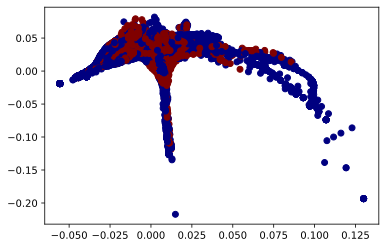

In [15]:
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

# perform kmeans clustering on data

from sklearn.cluster import KMeans
singledim = []
for snippet in zs:
    singledim.append(snippet[:,0])

results = []
for i in range(10000):
    kmeans_orig = KMeans(n_clusters=2).fit(singledim)
    found = False
    for temp in results:
        if (kmeans_orig.labels_ == temp[0]).all() or (kmeans_orig.labels_ != temp[0]).all():
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeans_orig.labels_, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
cluster_out = results[-1][0]
print(cluster_out)
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative=0
for i in range(len(zs_0)):
    if cluster_out[i] == 0:
        trueNegative += 1
    else:
        falsePositive += 1
for i in range(len(zs_0), len(zs)):
    if cluster_out[i] == 1:
        truePositive += 1
    else:
        falseNegative += 1
print("TN:", trueNegative)
print("FP:", falsePositive)
print("TP:", truePositive)
print("FN:", falseNegative)

In [16]:
# this will read the dtw matrix from the file
import pickle
try:
    #dtw_distmat.pickle is compressed and split into 100MB zip files in Github,
    # unzipped it is 1.5GB
    f = open("../dtw_distmat_zscore_dim_0.pickle", 'rb')
    dtw_distmat_dim_0 = pickle.load(f)
finally:
    f.close()

print(dtw_distmat_dim_0.shape)

(104, 104)


In [17]:
random.sample(range(104), 2)

[37, 39]

In [13]:
# build list of index pairs for the initial medoids
tot = 104 #len(zs)
idx = []
for i1 in range(tot):
    for j1 in range((tot-1)):
        temp = [i1,j1]
        idx.append(temp)
print(len(idx))
#print(len(zs) * (len(zs)-1))

10712


In [14]:
# kmedoids clustering function

from pyclustering.cluster.kmedoids import kmedoids

def try_medoids(nclust, dm, idx=None):
    len_data = dm.shape[0]
    if idx == None:
        initial_medoids = random.sample(range(len_data), nclust)
    else:
        initial_medoids = idx
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

In [20]:
# clustering results from dtw

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dtw_distmat_dim_0, idx=idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
print(len(results))
print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


2
########################################################################
before sorting
[[[[1, 2, 6, 7, 8, 10, 11, 12, 13, 14, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 43, 44, 45, 47, 50, 51, 53, 54, 56, 57, 60, 66, 67, 69, 70, 72, 74, 76, 79, 81, 82, 83, 85, 86, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [0, 3, 4, 5, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 35, 40, 42, 46, 48, 49, 52, 55, 58, 59, 61, 62, 63, 64, 65, 68, 71, 73, 75, 77, 78, 80, 84, 87, 88, 91]], 4593], [[[2, 6, 8, 11, 12, 13, 14, 15, 16, 24, 26, 29, 30, 32, 33, 34, 36, 37, 38, 41, 43, 44, 45, 47, 50, 53, 54, 60, 62, 63, 67, 69, 70, 72, 73, 77, 81, 82, 86, 89, 92, 93, 95, 96, 97, 99, 100, 101, 103], [0, 1, 3, 4, 5, 7, 9, 10, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 31, 35, 39, 40, 42, 46, 48, 49, 51, 52, 55, 56, 57, 58, 59, 61, 64, 65, 66, 68, 71, 74, 75, 76, 78, 79, 80, 83, 84, 85, 87, 88, 90, 91, 94, 98, 102]], 6119]]
after sorting
[[[[1, 2, 6, 7, 8, 10, 11, 12, 13, 14, 26, 27, 

In [21]:
# get results over all bins for dtw

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    res_temp = results[len(results)-1-i][1]
    print(res_temp)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)

[[2, 6, 8, 11, 12, 13, 14, 15, 16, 24, 26, 29, 30, 32, 33, 34, 36, 37, 38, 41, 43, 44, 45, 47, 50, 53, 54, 60, 62, 63, 67, 69, 70, 72, 73, 77, 81, 82, 86, 89, 92, 93, 95, 96, 97, 99, 100, 101, 103], [0, 1, 3, 4, 5, 7, 9, 10, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 31, 35, 39, 40, 42, 46, 48, 49, 51, 52, 55, 56, 57, 58, 59, 61, 64, 65, 66, 68, 71, 74, 75, 76, 78, 79, 80, 83, 84, 85, 87, 88, 90, 91, 94, 98, 102]]
6119
TN: 23
FP: 26
TP: 31
FN: 24
[[1, 2, 6, 7, 8, 10, 11, 12, 13, 14, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 43, 44, 45, 47, 50, 51, 53, 54, 56, 57, 60, 66, 67, 69, 70, 72, 74, 76, 79, 81, 82, 83, 85, 86, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [0, 3, 4, 5, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 35, 40, 42, 46, 48, 49, 52, 55, 58, 59, 61, 62, 63, 64, 65, 68, 71, 73, 75, 77, 78, 80, 84, 87, 88, 91]]
4593
TN: 26
FP: 35
TP: 22
FN: 21


In [22]:
# clustering results from manifolder with energy distance

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dcor_dm, idx=idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
        
print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


########################################################################
before sorting
[[[[0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [4, 5, 10, 13, 23, 24, 40, 45, 50, 79, 83]], 6739], [[[0, 3, 4, 5, 7, 8, 10, 13, 16, 17, 19, 20, 21, 22, 23, 24, 27, 29, 30, 33, 35, 38, 39, 40, 41, 45, 47, 48, 49, 50, 51, 54, 55, 56, 58, 59, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 82, 83, 84, 85, 88, 90, 91, 92, 93, 94, 101, 102], [1, 2, 6, 9, 11, 12, 14, 15, 18, 25, 26, 28, 31, 32, 34, 36, 37, 42, 43, 44, 46, 52, 53, 57, 60, 61, 64, 73, 77, 78, 81, 86, 87, 89, 95, 96, 97, 98, 99, 100, 103]], 3973]]
after sorting
[[[[0, 3, 4, 5, 7, 8, 10, 13, 16, 17, 19, 20, 21,

In [23]:
# get results over all Monte Carlo bins for manifolder with energy distance

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    res_temp = results[len(results)-1-i][1]
    print(res_temp)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)

[[0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [4, 5, 10, 13, 23, 24, 40, 45, 50, 79, 83]]
6739
TN: 39
FP: 54
TP: 3
FN: 8
[[0, 3, 4, 5, 7, 8, 10, 13, 16, 17, 19, 20, 21, 22, 23, 24, 27, 29, 30, 33, 35, 38, 39, 40, 41, 45, 47, 48, 49, 50, 51, 54, 55, 56, 58, 59, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 79, 80, 82, 83, 84, 85, 88, 90, 91, 92, 93, 94, 101, 102], [1, 2, 6, 9, 11, 12, 14, 15, 18, 25, 26, 28, 31, 32, 34, 36, 37, 42, 43, 44, 46, 52, 53, 57, 60, 61, 64, 73, 77, 78, 81, 86, 87, 89, 95, 96, 97, 98, 99, 100, 103]]
3973
TN: 26
FP: 37
TP: 20
FN: 21


# Accuracy for num_rdims = 10, manifolder dim =5
TN: 15
FP: 0
TP: 57
FN: 32

TN: 39
FP: 54
TP: 3
FN: 8

TN: 13
FP: 44
TP: 13
FN: 34


# Accuracy for num_rdims = 10, manifolder dim = 0
TN: 39
FP: 54
TP: 3
FN: 8

# Accuracy for num_rdims = 50, manifolder dim = 0
TN: 19
FP: 45
TP: 12
FN: 28

TN: 39
FP: 55
TP: 2
FN: 8

In [24]:
######################################################
#Cross-check of DTW versus Matlab
# This code is for verification only
######################################################

import math
x = []
for i in range(1000):
    x.append(math.cos(2*math.pi*((3*i/1000)**2)))
y = []
for i in range(400):
    y.append(math.cos(2*math.pi*18*i/400))

import dtw
temp = dtw.dtw(x,y)
print(temp.distance)

179.3527858690105


In [10]:
# calculate energy distance matrix for original data without manifolder dimensionality reduction

snippet_windows = []
H = 160
step_size = 20

for snip in range(len(zs)):
    z = zs[snip]
    i_range = int(np.floor(z.shape[0] - H) / step_size)
    window = np.zeros((H, i_range))
    #print(window.shape)
    for i in range(i_range):
        # interval = z(dim, 1 + (i - 1) * stepSize: (i - 1) * stepSize + H);
        interval = z[i * step_size:i * step_size + H, 0]
        #print(interval.shape)
        window[:, i] = interval
    snippet_windows.append(window)

print(snippet_windows)

import dcor
dcor_dm_nm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_windows)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_windows[i], snippet_windows[j])
        dcor_dm_nm[i,j] = distance
        dcor_dm_nm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
# print(dcor_dm_nm)

[array([[3.37, 3.57, 3.77, ..., 6.01, 6.64, 7.58],
       [3.44, 3.64, 3.78, ..., 6.32, 6.57, 7.62],
       [3.5 , 3.67, 3.77, ..., 6.31, 6.51, 7.57],
       ...,
       [3.72, 3.42, 3.62, ..., 8.  , 7.97, 6.97],
       [3.71, 3.52, 3.64, ..., 7.9 , 7.68, 7.  ],
       [3.8 , 3.58, 3.65, ..., 7.65, 7.39, 6.95]]), array([[ 9.12,  9.08,  8.92, ..., 12.29, 12.59, 12.88],
       [ 9.13,  9.1 ,  8.89, ..., 12.11, 12.51, 12.85],
       [ 9.17,  9.04,  8.91, ..., 12.  , 12.51, 12.86],
       ...,
       [ 8.39,  8.33,  8.39, ..., 12.81, 12.81, 13.3 ],
       [ 8.33,  8.26,  8.42, ..., 12.83, 12.94, 13.33],
       [ 8.29,  8.19,  8.4 , ..., 12.91, 12.92, 13.3 ]]), array([[13.73, 13.6 , 13.5 , ..., 13.3 , 13.17, 12.38],
       [13.75, 13.6 , 13.5 , ..., 13.33, 13.04, 12.36],
       [13.69, 13.66, 13.51, ..., 13.45, 13.03, 12.44],
       ...,
       [13.44, 13.66, 13.6 , ..., 12.83, 11.28, 10.06],
       [13.52, 13.55, 13.64, ..., 12.72, 11.13,  9.95],
       [13.62, 13.45, 13.65, ..., 12.64, 11


	 Dcor Executed in 18.86 seconds


In [26]:
# clustering results from original data with energy distance

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dcor_dm_nm, idx=idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])


print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


########################################################################
before sorting
[[[[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 23, 24, 25, 26, 28, 30, 31, 34, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 59, 61, 62, 63, 64, 65, 69, 72, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 99, 100, 102, 103], [0, 7, 8, 16, 19, 20, 22, 27, 29, 32, 33, 35, 39, 41, 48, 54, 58, 60, 66, 67, 68, 70, 71, 73, 74, 75, 76, 82, 84, 90, 94, 98, 101]], 10712]]
after sorting
[[[[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 23, 24, 25, 26, 28, 30, 31, 34, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 59, 61, 62, 63, 64, 65, 69, 72, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 99, 100, 102, 103], [0, 7, 8, 16, 19, 20, 22, 27, 29, 32, 33, 35, 39, 41, 48, 54, 58, 60, 66, 67, 68, 70, 71, 73, 74, 75, 76, 82, 84, 90, 94, 98, 101]], 10712]]
##############################################

In [27]:
# get results over all Monte Carlo bins for original data with energy distance

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    res_temp = results[len(results)-1-i][1]
    print(res_temp)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)

[[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 23, 24, 25, 26, 28, 30, 31, 34, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 59, 61, 62, 63, 64, 65, 69, 72, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 99, 100, 102, 103], [0, 7, 8, 16, 19, 20, 22, 27, 29, 32, 33, 35, 39, 41, 48, 54, 58, 60, 66, 67, 68, 70, 71, 73, 74, 75, 76, 82, 84, 90, 94, 98, 101]]
10712
TN: 33
FP: 38
TP: 19
FN: 14


In [28]:
# calculate euclidean distance matrix for original data

euclid_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(zs)):
    for j in range(i):
        distance = np.linalg.norm(zs[i] - zs[j])
        euclid_dm[i,j] = distance
        euclid_dm[j,i] = distance


In [29]:
# clustering results from original data with Euclidean distance

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, euclid_dm, idx=idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])

print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")

########################################################################
before sorting
[[[[2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 17, 21, 23, 24, 25, 26, 28, 30, 31, 36, 38, 40, 42, 43, 44, 45, 47, 50, 51, 52, 53, 55, 57, 59, 62, 63, 64, 69, 72, 79, 80, 81, 83, 86, 87, 88, 89, 91, 95, 100, 103], [0, 1, 7, 8, 9, 16, 18, 19, 20, 22, 27, 29, 32, 33, 34, 35, 37, 39, 41, 46, 48, 49, 54, 56, 58, 60, 61, 65, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 82, 84, 85, 90, 92, 93, 94, 96, 97, 98, 99, 101, 102]], 8421], [[[7, 8, 16, 19, 20, 22, 27, 29, 33, 35, 48, 54, 58, 68, 70, 71, 75, 76, 82, 84, 90, 101], [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 23, 24, 25, 26, 28, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 72, 73, 74, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103]], 2291]]
after sorting
[[[[7, 8, 16, 19, 20, 22, 27, 29, 33, 35, 48, 54,

In [30]:
# get results over all Monte Carlo bins for Euclidean

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    res_temp = results[len(results)-1-i][1]
    print(res_temp)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative = 0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 17, 21, 23, 24, 25, 26, 28, 30, 31, 36, 38, 40, 42, 43, 44, 45, 47, 50, 51, 52, 53, 55, 57, 59, 62, 63, 64, 69, 72, 79, 80, 81, 83, 86, 87, 88, 89, 91, 95, 100, 103], [0, 1, 7, 8, 9, 16, 18, 19, 20, 22, 27, 29, 32, 33, 34, 35, 37, 39, 41, 46, 48, 49, 54, 56, 58, 60, 61, 65, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 82, 84, 85, 90, 92, 93, 94, 96, 97, 98, 99, 101, 102]]
8421
TN: 27
FP: 25
TP: 32
FN: 20
[[7, 8, 16, 19, 20, 22, 27, 29, 33, 35, 48, 54, 58, 68, 70, 71, 75, 76, 82, 84, 90, 101], [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 23, 24, 25, 26, 28, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 72, 73, 74, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103]]
2291
TN: 10
FP: 12
TP: 45
FN: 37


In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=num_rdims)

pca_snippets = []
for snippet_window in snippet_windows:
    pca_result = pca.fit_transform(snippet_window)
    print(pca_result)
    #print(pca_result.shape)
    pca_snippets.append(pca_result)

import dcor
dcor_dm_pca = np.zeros((len(zs), len(zs)))
for i in range(len(snippet_windows)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_windows[i], snippet_windows[j])
        dcor_dm_pca[i,j] = distance
        dcor_dm_pca[j,i] = distance

[[-10.4389   5.2514   3.6989 ...  -0.3321  -0.2003  -0.471 ]
 [-10.4903   5.2406   3.7003 ...  -0.5547   0.0962  -0.7343]
 [-10.4318   5.0139   3.456  ...  -0.5349   0.0352  -0.6942]
 ...
 [  8.6604   5.0174  -3.4201 ...  -2.1378  -0.1857   0.1415]
 [  9.2988   5.021   -3.2964 ...  -1.8053   0.0304   0.2161]
 [ 10.5273   5.3161  -3.0394 ...  -0.9746   0.1454  -0.075 ]]
[[-3.5787  1.7349  1.0506 ... -0.2258  0.1217 -0.323 ]
 [-3.5648  1.6682  1.0591 ... -0.288   0.1759 -0.3071]
 [-3.4985  1.623   1.0005 ... -0.2684  0.2391 -0.2565]
 ...
 [ 3.7239  1.6406 -0.5608 ... -0.4032 -0.0261 -0.1501]
 [ 3.8032  1.6522 -0.6521 ... -0.432   0.033  -0.0207]
 [ 3.6932  1.7014 -0.7568 ... -0.402   0.0874  0.0029]]
[[-1.1488  0.7349  1.324  ... -0.5432 -0.0453 -0.1262]
 [-1.2332  0.7977  1.3421 ... -0.5253 -0.073  -0.0782]
 [-1.3244  0.8214  1.4962 ... -0.3255 -0.1652 -0.0597]
 ...
 [ 2.0158  2.1772 -1.3268 ...  0.0579 -0.4317 -0.0055]
 [ 1.8408  2.2049 -1.5483 ...  0.0404 -0.3931  0.0514]
 [ 1.7282  2

 [ 17.7788 -18.7763   9.8774 ...   3.2819  -1.6978  -1.1892]]
[[-14.8871  14.8716  11.7564 ...  -0.3369   0.9473   4.5968]
 [-16.0465  14.4241  11.1918 ...  -0.9743   0.1647   2.9525]
 [-16.2106  14.2888  11.0568 ...  -1.0675  -0.053    1.7592]
 ...
 [ 15.5566  15.3357  -8.6794 ...   3.1425   4.0583  -0.224 ]
 [ 15.5856  15.4499  -8.5486 ...   2.4061   4.7882   0.586 ]
 [ 16.3082  16.2066  -8.492  ...   1.9839   6.6947   1.1427]]
[[-10.5834  -9.4415   9.9569 ...  -0.654   -4.7426   5.2367]
 [-10.1982  -9.3744  10.7835 ...  -0.5409  -3.7227   4.5585]
 [ -9.7718  -8.3383  12.776  ...  -0.8508  -2.211    3.0465]
 ...
 [ 10.1509  -8.1521 -11.2557 ...   8.7954  -1.9859  -0.7978]
 [ 10.0879  -7.0378 -11.2222 ...   8.701   -1.9451  -1.621 ]
 [  9.8496  -6.3017 -10.654  ...   7.6388  -1.3525  -2.1183]]
[[ 84.4303  27.4525 -11.5068 ...   5.577    1.8714 -13.3687]
 [ 83.8253  29.3461 -10.8787 ...   7.3288   2.8432 -12.1841]
 [ 84.7234  29.9085 -10.4831 ...   6.5218   2.3894 -10.0886]
 ...
 [-79.

In [16]:
# clustering results from PCA with energy distance

results = []
for i in range(len(idx)):
    kmeds = try_medoids(2, dcor_dm_pca, idx=idx[i])
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
        
print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


########################################################################
before sorting
[[[[7, 10, 11, 15, 19, 21, 23, 24, 26, 30, 34, 37, 43, 45, 47, 53, 56, 58, 60, 62, 67, 68, 70, 72, 73, 74, 81, 83, 87, 89, 93, 97, 99], [0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 14, 16, 17, 18, 20, 22, 25, 27, 28, 29, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 44, 46, 48, 49, 50, 51, 52, 54, 55, 57, 59, 61, 63, 64, 65, 66, 69, 71, 75, 76, 77, 78, 79, 80, 82, 84, 85, 86, 88, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103]], 10712]]
after sorting
[[[[7, 10, 11, 15, 19, 21, 23, 24, 26, 30, 34, 37, 43, 45, 47, 53, 56, 58, 60, 62, 67, 68, 70, 72, 73, 74, 81, 83, 87, 89, 93, 97, 99], [0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 14, 16, 17, 18, 20, 22, 25, 27, 28, 29, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 44, 46, 48, 49, 50, 51, 52, 54, 55, 57, 59, 61, 63, 64, 65, 66, 69, 71, 75, 76, 77, 78, 79, 80, 82, 84, 85, 86, 88, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103]], 10712]]
##############################################

In [17]:
# get results over all Monte Carlo bins for PCA with energy distance

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    res_temp = results[len(results)-1-i][1]
    print(res_temp)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)

[[7, 10, 11, 15, 19, 21, 23, 24, 26, 30, 34, 37, 43, 45, 47, 53, 56, 58, 60, 62, 67, 68, 70, 72, 73, 74, 81, 83, 87, 89, 93, 97, 99], [0, 1, 2, 3, 4, 5, 6, 8, 9, 12, 13, 14, 16, 17, 18, 20, 22, 25, 27, 28, 29, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 44, 46, 48, 49, 50, 51, 52, 54, 55, 57, 59, 61, 63, 64, 65, 66, 69, 71, 75, 76, 77, 78, 79, 80, 82, 84, 85, 86, 88, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103]]
10712
TN: 14
FP: 19
TP: 38
FN: 33
